In [1]:
import os, sys
sys.path.append(os.path.abspath('../utils'))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.io import loadmat
import pickle
import surd as surd
from collections import defaultdict
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from IPython.display import display
import itertools
from collections import defaultdict
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.utils.GraphUtils import GraphUtils

In [2]:
wave5 = pd.read_csv('../data/wave5NEW.csv')  
wave6 = pd.read_csv('../data/wave6NEW.csv')

In [3]:
# Inner join to ensure both waves have the same PIDs
common_pids = set(wave5['PID']).intersection(set(wave6['PID']))

wave5 = wave5[wave5['PID'].isin(common_pids)].copy()
wave6 = wave6[wave6['PID'].isin(common_pids)].copy()

# Sort both DataFrames by PID
wave5 = wave5.sort_values('PID').reset_index(drop=True)
wave6 = wave6.sort_values('PID').reset_index(drop=True)

In [4]:
w5 = wave5[['support_cc_policy', 'attitudes_cc', 'support_govern_cv', 'trust_officials', 'harm_ex_weather']]
w6 = wave6[['support_cc_policy', 'attitudes_cc', 'support_govern_cv', 'trust_officials', 'harm_ex_weather']]

data = pd.concat([w5, w6], ignore_index=True)

In [5]:
# Ensure both dataframes are aligned and have the same structure
assert w5.shape == w6.shape, "w5 and w6 must have the same shape"
assert list(w5.columns) == list(w6.columns), "Column names must match"

# Interleave rows
interleaved_rows = [row for i in range(len(w5)) for row in (w5.iloc[i], w6.iloc[i])]

# Convert to DataFrame with same columns
interleaved_df = pd.DataFrame(interleaved_rows, columns=w5.columns).reset_index(drop=True)

**Plot distributions of the five variables**

Support for climate policy, attitudes toward climate change, support for COVID-19 interventions and harm experienced because of extreme weather. 

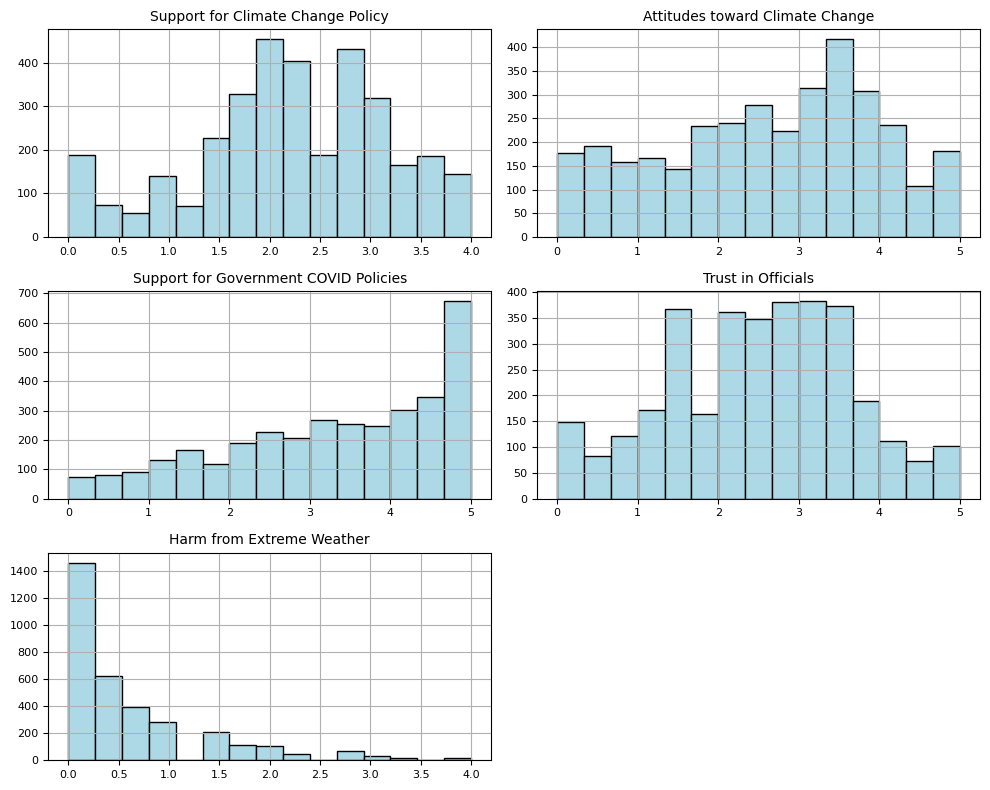

In [6]:
# 3 rows x 2 columns to fit 5 plots
fig, axs = plt.subplots(3, 2, figsize=(10, 8))  
axs = axs.flatten()

# Define variable names and titles
columns = ['support_cc_policy', 'attitudes_cc', 'support_govern_cv', 'trust_officials', 'harm_ex_weather']
titles = [
    'Support for Climate Change Policy',
    'Attitudes toward Climate Change',
    'Support for Government COVID Policies',
    'Trust in Officials',
    'Harm from Extreme Weather'
]

# Plot each histogram
for i, (col, title) in enumerate(zip(columns, titles)):
    interleaved_df[col].hist(ax=axs[i], bins=15, edgecolor='black', color='#add8e6')
    axs[i].set_title(title, fontsize=10)
    axs[i].tick_params(axis='x', labelsize=8)
    axs[i].tick_params(axis='y', labelsize=8)

axs[-1].axis('off')

fig.tight_layout()

fig.savefig("combined_histograms_concepts.png", dpi=300, bbox_inches='tight')

plt.show()


**SURD run**

Output visualized by surd.nice_print() function

In [7]:
X = interleaved_df.T.to_numpy()

# Number of variables
nvars = X.shape[0]
print(X.shape)

# Define number of bins for discretization
nbins = 2

# Select the time lags 
nlags = np.array([1, 1, 1, 1, 1])

# Storing results
I_R_results = {}  # Redundant contributions
I_S_results = {}  # Synergistic contributions
MI_results = {}   # Mutual information
info_leak_results = {}  # Information leak

# Iterate over each variable as the target
for i in range(nvars):
    target = i
    agent_indices = [j for j in range(nvars) if j != target]  # Exclude the target variable
    print('agent indices: ', agent_indices)

    print(f'\n🔹 SURD CAUSALITY FOR TARGET VARIABLE: {target}')

    # Organize data: target variable and agent variables
    Y_target = X[target, nlags[target]:]  # Target variable data
    Y_agents = X[agent_indices, :-nlags[target]]  # Exclude the target variable from agents

    # Stack for SURD
    Y = np.vstack([Y_target, Y_agents])

    # Run SURD
    hist, _ = np.histogramdd(Y.T, bins=nbins)
    I_R, I_S, MI, info_leak = surd.surd(hist)

    # Print results
    surd.nice_print(I_R, I_S, MI, info_leak)
    print('\n')

    # Store the results
    I_R_results[target] = I_R
    I_S_results[target] = I_S
    MI_results[target] = MI
    info_leak_results[target] = info_leak

(5, 3376)
agent indices:  [1, 2, 3, 4]

🔹 SURD CAUSALITY FOR TARGET VARIABLE: 0
    Redundant (R):
        (1, 2)      : 0.0194
        (1, 3)      : 0.0024
        (1, 4)      : 0.0000
        (2, 3)      : 0.0000
        (2, 4)      : 0.0000
        (3, 4)      : 0.0000
        (1, 2, 3)   : 0.4473
        (1, 2, 4)   : 0.0000
        (1, 3, 4)   : 0.0000
        (2, 3, 4)   : 0.0000
        (1, 2, 3, 4): 0.0021
    Unique (U):
        (1,)        : 0.2307
        (2,)        : 0.0000
        (3,)        : 0.0000
        (4,)        : 0.0000
    Synergystic (S):
        (1, 2)      : 0.1360
        (1, 3)      : 0.0314
        (1, 4)      : 0.0136
        (2, 3)      : 0.0023
        (2, 4)      : 0.0000
        (3, 4)      : 0.0000
        (1, 2, 3)   : 0.0726
        (1, 2, 4)   : 0.0000
        (1, 3, 4)   : 0.0194
        (2, 3, 4)   : 0.0000
        (1, 2, 3, 4): 0.0229
    Information Leak: 94.75%


agent indices:  [0, 2, 3, 4]

🔹 SURD CAUSALITY FOR TARGET VARIABLE: 1
    Redun

In [12]:
# PARAMETERS
n_permutations = 1000
nbins = 2
nlags = np.array([1] * 5)

# STORAGE
null_vectors = defaultdict(list)  # {target: [vectors]}
null_dict = defaultdict(lambda: {  # {target: {'redundancy': {}, 'unique': {}, 'synergy': {}}}
    'redundancy': defaultdict(list),
    'unique': defaultdict(list),
    'synergy': defaultdict(list)
})
real_vectors = dict()  # {target: vector}
key_orders = dict()    # {target: (redundancy_keys, unique_keys, synergy_keys)}

# HELPER
def flatten_surd_output(I_R_norm, I_S_norm, key_order=None):
    redundancy_keys = sorted([k for k in I_R_norm if len(k) > 1])
    unique_keys = [(1,), (2,), (3,), (4,)]  
    synergy_keys = sorted(list(I_S_norm.keys()))

    if key_order is None:
        key_order = (redundancy_keys, unique_keys, synergy_keys)

    R_vec = [I_R_norm.get(k) for k in key_order[0]]
    U_vec = [I_R_norm.get(k) for k in key_order[1]]
    S_vec = [I_S_norm.get(k) for k in key_order[2]]

    full_vector = R_vec + U_vec + S_vec
    return full_vector, key_order
    
# PERMUTATION TESTING
for p in range(n_permutations):
    X_perm = interleaved_df.sample(frac=1).reset_index(drop=True).T.to_numpy()

    for target in range(X_perm.shape[0]):
        agent_indices = [j for j in range(X_perm.shape[0]) if j != target]
        Y_target = X_perm[target, nlags[target]:]
        Y_agents = X_perm[agent_indices, :-nlags[target]]
        Y = np.vstack([Y_target, Y_agents])

        hist, _ = np.histogramdd(Y.T, bins=nbins)
        I_R, I_S, MI, _ = surd.surd(hist)

        max_mi = max(MI.values())
        I_R_norm = {k: v / max_mi for k, v in I_R.items()}
        I_S_norm = {k: v / max_mi for k, v in I_S.items()}

        # Build vector
        if p == 0:
            flat_vec, key_order = flatten_surd_output(I_R_norm, I_S_norm)
            key_orders[target] = key_order
        else:
            flat_vec, _ = flatten_surd_output(I_R_norm, I_S_norm, key_order=key_orders[target])

        null_vectors[target].append(flat_vec)

        # Fill null_dict separately by type
        redundancy_keys, unique_keys, synergy_keys = key_orders[target]
        for i, k in enumerate(redundancy_keys):
            null_dict[target]['redundancy'][k].append(flat_vec[i])
        for i, k in enumerate(unique_keys):
            null_dict[target]['unique'][k].append(flat_vec[len(redundancy_keys) + i])
        for i, k in enumerate(synergy_keys):
            null_dict[target]['synergy'][k].append(flat_vec[len(redundancy_keys) + len(unique_keys) + i])

# REAL DATA
X_real = interleaved_df.T.to_numpy()

for target in range(X_real.shape[0]):
    agent_indices = [j for j in range(X_real.shape[0]) if j != target]
    Y_target = X_real[target, nlags[target]:]
    Y_agents = X_real[agent_indices, :-nlags[target]]
    Y = np.vstack([Y_target, Y_agents])

    hist, _ = np.histogramdd(Y.T, bins=nbins)
    I_R, I_S, MI, _ = surd.surd(hist)

    max_mi = max(MI.values())
    I_R_norm = {k: v / max_mi for k, v in I_R.items()}
    I_S_norm = {k: v / max_mi for k, v in I_S.items()}

    real_vec, _ = flatten_surd_output(I_R_norm, I_S_norm, key_order=key_orders[target])
    real_vectors[target] = real_vec

In [13]:
def summarize_mahalanobis_against_null_mean(target):
    """
    Computes Mahalanobis distance between a real SURD vector and null permutations.
    Returns a single-row DataFrame with:
    - Real distance
    - Mean null distance
    - Min and max null distances (bounds)
    - Empirical p-value
    """

    # step 1: Get data
    null_arr = np.array(null_vectors[target])           # (n_permutations, n_features)
    real_vec = np.array(real_vectors[target])           # (n_features,)
    mean_vec = np.mean(null_arr, axis=0)
    cov_matrix = np.cov(null_arr, rowvar=False)
    inv_cov = np.linalg.pinv(cov_matrix)

    # Step 2: Mahalanobis distances for null permutations 
    mahal_dists = []
    for i in range(null_arr.shape[0]):
        diff = null_arr[i] - mean_vec
        mahal_sq = np.dot(np.dot(diff, inv_cov), diff.T)
        mahal_dists.append(mahal_sq)

    # Step 3: Mahalanobis distance for real vector
    diff_real = real_vec - mean_vec
    real_mahal_sq = np.dot(np.dot(diff_real, inv_cov), diff_real.T)

    # Step 4: Empirical p-value (from permutation distribution)
    count = np.sum(np.array(mahal_dists) >= real_mahal_sq)
    p_empirical = (count + 1) / (len(mahal_dists) + 1)

    # Step 5: Summary Output
    summary_df = pd.DataFrame([{
        "Target": target,
        "Real_Mahalanobis": real_mahal_sq,
        "Null_Min_Distance": np.min(mahal_dists),
        "Null_Max_Distance": np.max(mahal_dists),
        "Empirical_p": p_empirical
    }])

    return summary_df

# Run for all 5 targets and combine results
all_results = pd.concat([summarize_mahalanobis_against_null_mean(t) for t in range(5)], ignore_index=True)

print(all_results)

   Target  Real_Mahalanobis  Null_Min_Distance  Null_Max_Distance  Empirical_p
0       0        584.921051           3.635114         305.828235     0.000999
1       1        285.266169           3.888641         221.788026     0.000999
2       2        413.655421           3.906946         227.138511     0.000999
3       3        339.194423           3.299180         193.559548     0.000999
4       4         20.024329           3.872309         332.243610     0.453546


In [10]:
def surd_subset_test(interleaved_df, target, agents, n_permutations=1000, nbins=2, nlags=1, seed=None):
    """
    Runs SURD with a specified target and agent subset.
    Compares sum of unnormalized SURD outputs against permutation-based null model.

    Parameters:
    - interleaved_df: Input DataFrame with wave-aligned rows.
    - target: int, index of the target variable.
    - agents: list of int, indices of agent variables.
    - n_permutations: number of random shuffles.
    - nbins: bins used for histogramdd (default 2).
    - nlags: lag to apply (same for all variables).
    - seed: random seed for reproducibility.

    Returns:
    - real_value: float, sum of SURD values on real data.
    - null_values: list of float, summed values from permutations.
    - p_value: float, empirical p-value.
    """
    if seed is not None:
        np.random.seed(seed)

    null_values = []

    X = interleaved_df.T.to_numpy()
    nvars = X.shape[0]

    # Permutation Testing
    for _ in range(n_permutations):
        perm_df = interleaved_df.sample(frac=1).reset_index(drop=True)
        X_perm = perm_df.T.to_numpy()

        Y_target = X_perm[target, nlags:]
        Y_agents = X_perm[agents, :-nlags]
        Y = np.vstack([Y_target, Y_agents])
        
        hist, _ = np.histogramdd(Y.T, bins=nbins)
        I_R, I_S, MI, _ = surd.surd(hist)

        total_info = sum(I_R.values()) + sum(I_S.values()) 
        null_values.append(total_info)
        #print(total_info)
        #break

    # Real SURD
    Y_target = X[target, nlags:]
    Y_agents = X[agents, :-nlags]
    Y = np.vstack([Y_target, Y_agents])

    hist, _ = np.histogramdd(Y.T, bins=nbins)
    I_R, I_S, MI, _ = surd.surd(hist)
    real_value = sum(I_R.values()) + sum(I_S.values())
    #print(real_value)

    # Empirical p-value
    p_val = (np.sum(np.array(null_values) >= real_value) + 1) / (len(null_values) + 1)

    print(f"Target: {target}, Agents: {agents}")
    print(f"Real SUM SURD (R + S): {real_value:.4f}")
    print(f"Mean of permuted SUMs: {np.mean(null_values):.4f}")
    print(f"Empirical p-value: {p_val:.4f}")

    return real_value, null_values, p_val


In [11]:
# Run test
real_val, null_vals, p = surd_subset_test(
    interleaved_df, 
    target=0, 
    agents=[2,4], 
    n_permutations=1000, 
    nbins=2, 
    nlags=1,
    seed=42
)

Target: 0, Agents: [2, 4]
Real SUM SURD (R + S): 0.0228
Mean of permuted SUMs: 0.0006
Empirical p-value: 0.0010


In [27]:
def run_surd_exhaustive_search(interleaved_df, nvars, alpha=0.01, n_permutations=1000, nbins=2, nlags=1, seed=None):
    """
    Run surd_subset_test for all valid combinations of agents for all targets.

    Parameters:
    - interleaved_df: DataFrame with interleaved wave rows.
    - nvars: total number of variables.
    - alpha: significance level.
    - n_permutations: number of permutations.
    - nbins: histogram bin size for SURD.
    - nlags: lag (same for all variables).
    - seed: random seed for reproducibility.

    Returns:
    - significant_combinations: dict[target] = list of (agents, p_value)
    - insignificant_combinations: dict[target] = list of (agents, p_value)
    """

    significant_combinations = defaultdict(list)
    insignificant_combinations = defaultdict(list)

    for target in range(nvars):
        possible_agents = [i for i in range(nvars) if i != target]

        # Iterate over all agent subsets
        for r in range(1, min(5, len(possible_agents)+1)):
            #print('AGENT SUBSET:    ', agent_subset)
            for agent_subset in itertools.combinations(possible_agents, r):
                print('AGENT SUBSET:    ', agent_subset)
                real_val, null_vals, p_val = surd_subset_test(
                    interleaved_df,
                    target,
                    agents=list(agent_subset),
                    n_permutations=n_permutations,
                    nbins=nbins,
                    nlags=nlags,
                    seed=seed
                )

                if p_val < alpha:
                    significant_combinations[target].append((agent_subset, p_val))
                else:
                    insignificant_combinations[target].append((agent_subset, p_val))

    return significant_combinations, insignificant_combinations


In [28]:
sig, insignif = run_surd_exhaustive_search(interleaved_df, nvars=5, alpha=0.01)

AGENT SUBSET:     (1,)
Target: 0, Agents: [1]
Real SUM SURD (R + S): 0.0334
Mean of permuted SUMs: 0.0002
Empirical p-value: 0.0010
AGENT SUBSET:     (2,)
Target: 0, Agents: [2]
Real SUM SURD (R + S): 0.0223
Mean of permuted SUMs: 0.0002
Empirical p-value: 0.0010
AGENT SUBSET:     (3,)
Target: 0, Agents: [3]
Real SUM SURD (R + S): 0.0215
Mean of permuted SUMs: 0.0002
Empirical p-value: 0.0010
AGENT SUBSET:     (4,)
Target: 0, Agents: [4]
Real SUM SURD (R + S): 0.0001
Mean of permuted SUMs: 0.0002
Empirical p-value: 0.5125
AGENT SUBSET:     (1, 2)
Target: 0, Agents: [1, 2]
Real SUM SURD (R + S): 0.0406
Mean of permuted SUMs: 0.0006
Empirical p-value: 0.0010
AGENT SUBSET:     (1, 3)
Target: 0, Agents: [1, 3]
Real SUM SURD (R + S): 0.0421
Mean of permuted SUMs: 0.0006
Empirical p-value: 0.0010
AGENT SUBSET:     (1, 4)
Target: 0, Agents: [1, 4]
Real SUM SURD (R + S): 0.0340
Mean of permuted SUMs: 0.0006
Empirical p-value: 0.0010
AGENT SUBSET:     (2, 3)
Target: 0, Agents: [2, 3]
Real SUM S

In [29]:
insignif

defaultdict(list,
            {0: [((4,), 0.5124875124875125)],
             1: [((4,), 0.4195804195804196)],
             2: [((4,), 0.053946053946053944)],
             3: [((4,), 0.3246753246753247)],
             4: [((0,), 0.04895104895104895),
              ((2,), 0.2627372627372627),
              ((3,), 0.17382617382617382),
              ((0, 2), 0.1848151848151848),
              ((0, 3), 0.03196803196803197),
              ((2, 3), 0.15784215784215785),
              ((0, 2, 3), 0.030969030969030968)]})